In [22]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter
device = th.device('cpu')
# pqr
P = 3
Q = 701
R = 3
# klmn
N1 = 5
N2 = 5
N3 = 5
N4 = 140
# abcd
W1 = 20
W2 = 20
W3 = 1
W4 = 5
# xy
X1 = 1
X2 = 1

METER = 1e9
SEC = 1

dtype = th.complex128
real = th.float64

In [23]:
th.cuda.empty_cache()
width1_t, width2_t, width3_t, width4_t = \
85e-6 * METER, 85e-6 * METER, 1778e-6 * METER, 85e-6 * METER
x1_t, x2_t = \
0.009815 * METER, 0.489 * METER

width1, width2, width3, width4 = \
np.linspace(10e-6, 100e-6, W1) * METER, \
np.linspace(50e-6, 100e-6, W2) * METER, \
np.linspace(1500e-6, 2000e-6, W3) * METER, \
np.linspace(50e-6, 100e-6, W4) * METER

x1, x2 = \
th.linspace(0.007, 0.01, X1, device=device) * METER, \
th.linspace(0.35, 0.6, X2, device=device) * METER

if X1 == 1: x1 = th.tensor([x1_t], device=device)
if X2 == 1: x2 = th.tensor([x2_t], device=device)
if W3 == 1: width3 = np.array([width3_t])

LAMBDA = 670e-9 * METER
K = 2 * np.pi / LAMBDA
MUL = lambda x: th.exp(1j * K * x) / x

In [24]:
position1 = np.linspace(1e-3 * METER, 10e-3 * METER, N1)
position2 = np.linspace(16e-3 * METER, 10e-3 * METER, N2)
position3 = np.linspace(1e-3 * METER, 10e-3 * METER, N3)
position4 = np.linspace(1e-3 * METER, 8e-3 * METER, N4)

field1 = th.tensor(np.linspace(position1, position1[None, :] + width1[:, None], P), dtype=dtype, device=device) # P, W1, N1
field2 = th.tensor(np.linspace(position2, position2[None, :] + width2[:, None], P), dtype=dtype, device=device) # P, W2, N2
field3 = th.tensor(np.linspace(position3, position3[None, :] + width3[:, None], Q), dtype=dtype, device=device) # Q, W3, N3
field4 = th.tensor(np.linspace(position4, position4[None, :] + width4[:, None], R), dtype=dtype, device=device) # R, W4, N4

E1 = th.ones_like(field1, dtype=dtype, device=device) # P, W1, N1
E2 = th.ones_like(field2, dtype=dtype, device=device) # P, W2, N2

D1 = th.sqrt((x1 ** 2)[:, None, None, None, None, None, None] + 
    th.square(field1[:, None, :, None, :, None]-field3[None, :, None, :, None, :])[None, ...]) 
# X1, P, Q, W1, W3, N1, N3
D2 = th.sqrt((x1 ** 2)[:, None, None, None, None, None, None] + 
    th.square(field2[:, None, :, None, :, None]-field3[None, :, None, :, None, :])[None, ...])
# X1, P, Q, W2, W3, N2, N3
D3 = th.sqrt((x2 ** 2)[:, None, None, None, None, None, None] + 
    th.square(field3[:, None, :, None, :, None]-field4[None, :, None, :, None, :])[None, ...])
# X2, Q, R, W3, W4, N3, N4
E3 = th.einsum('xpqackm,pak->xqackm', MUL(D1), E1)[:, :, :, None, :, :, None, :] \
  + th.einsum('xpqbclm,pbl->xqbclm', MUL(D2), E2)[:, :, None, :, :, None, :, :]
# X1, Q, W1, W2, W3, N1, N2, N3

th.cuda.empty_cache()
result = th.abs(th.einsum('yqrcdmn,xqabcklm->xyrabcdklmn', MUL(D3), E3))
# X1, X2, R, W1, W2, W3, W4, N1, N2, N3, N4

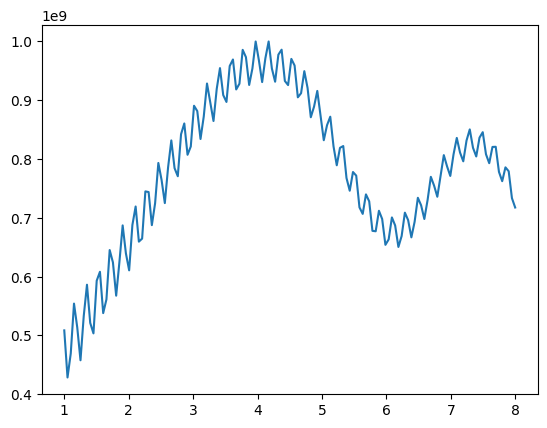

In [25]:

result = th.sum(result, dim=2)
max_val, _ = th.max(result, dim=-1)
result = result / max_val[..., None]
plt.plot(position4 / METER * 1e3, result[0, 0, 0, 0, 0, 0, 0, 0, 0,  :].to("cpu").numpy() * METER)

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rc('font', family='AppleGothic') 			## 이 두 줄을 
# plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

# path = "./LASER/B-1/"
# filename = lambda x: path + "B-1_DoubleSlit_" + str(x) + ".csv"
filename = lambda x:"/Users/rainy21/IPL1/single-photon-interference/LASER/B-3/B-3_AsymmDoubleSlit_Blocker2.33_14.csv"
POSITION_COL = "detector_position(mm)"
VOLTAGE_COL = "voltage(V)"
MILIVOLTE_COL = "voltage(mV)"

def get_data(x):
  data = pd.read_csv(filename(x))
  if MILIVOLTE_COL in data.columns:
    data[VOLTAGE_COL] = data[MILIVOLTE_COL] / 1000
  data = data[data[POSITION_COL] < 8]
  pos = data[POSITION_COL]
  volt = data[VOLTAGE_COL]
  return pos, volt

def plot_data(x, volt=None):
  pos, origninal_volt = get_data(x)
  if volt == None: volt = origninal_volt
  # plt.plot(pos, volt, color='red', linestyle='solid', marker='o', mfc='black', mec='black', ms=3)
  plt.scatter(pos, volt, color='black', s=4)
  plt.xlabel("Detecor Position (mm)")
  plt.ylabel("Output Voltage (V)")
  plt.title(f"Detecor Position vs Output Voltage({str(x)})")

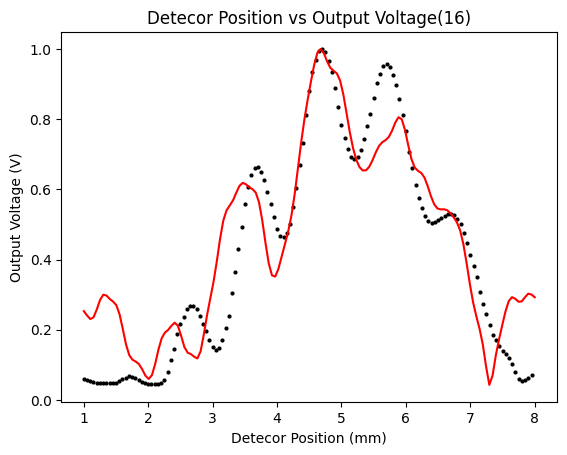

In [27]:
pos, volt = get_data(16)
volt = np.array(volt)
volt = volt / np.max(volt)
volt = th.tensor(volt, dtype=real, device=device)
error = (th.sum(th.square(result-volt), dim=-1))
# error min 위치
arg = th.argmin(error)
plot(position4/ METER * 1e3, result.view(-1, N4)[arg].cpu().numpy(), color='r')
# plot(pos, volt.cpu().numpy())
plot_data(16, volt.cpu())

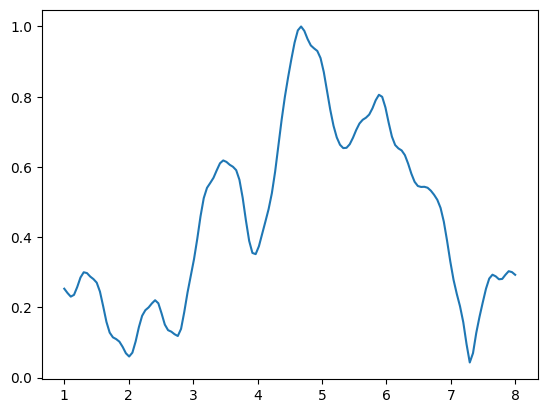

In [28]:
def unravel_index(index, shape):
    out = []
    for dim in reversed(shape):
        out.append(index % dim)
        index = int(index) // dim
    return tuple(reversed(out))

plot(position4/ METER * 1e3, result[unravel_index(arg, error.shape)].cpu())

In [29]:
# X1, X2, W1, W2, W3, W4, N1, N2, N3
def print_param_values(incidices):
  print("Slit <-> Blocker: ", float(x1[incidices[0]] / METER * 1e3), "mm", "True: 9.815mm")
  print("Blocker <-> Detector: ", float(x2[incidices[1]] / METER * 1e3), "mm", "True: 489mm")
  print("Slit Width: ", width1[incidices[2]] / METER * 1e6, "µm, ", width2[incidices[3]] / METER * 1e6, "µm", "True: 85µm")
  print("Blocker Width: ", width3[incidices[4]] / METER * 1e6, "mm", "True: 1.778mm")
  print("Detector Width: ", width4[incidices[5]] / METER * 1e6, "mm", "True: 85µm")
  print("Slit Position: ", position1[incidices[6]] / METER * 1e3, "mm, ", position2[incidices[7]] / METER * 1e3, "mm")
  print("Inter-slit Distance: ", abs(position1[incidices[6]] / METER * 1e3 - position2[incidices[7]] / METER * 1e3), "mm", "True: Dependss")
  print("Blocker Position: ", position3[incidices[8]] / METER * 1e3, "mm")

print_param_values(unravel_index(arg, error.shape))

Slit <-> Blocker:  9.8149995803833 mm True: 9.815mm
Blocker <-> Detector:  489.0 mm True: 489mm
Slit Width:  43.15789473684211 µm,  84.21052631578948 µm True: 85µm
Blocker Width:  1778.0 mm True: 1.778mm
Detector Width:  50.0 mm True: 85µm
Slit Position:  1.0 mm,  10.0 mm
Inter-slit Distance:  9.0 mm True: Dependss
Blocker Position:  3.25 mm


In [ ]:
arg

tensor(78740)